# Classification Modeling - Update

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Import modeling tools, pipelines, models, and metrics
import shap

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

set_config(transform_output='pandas')

# Load Data

In [4]:
df_data = pd.read_parquet('../../data/5.3_exploded_data_with_occupancies.parquet')
df_data

,IsCanceled,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,...,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,Date_DaysBeforeHoliday,Date_DaysAfterHoliday,DateWeek,DateDay,DateDayName,DateMonthName,TotalCheckOutReservations,PercentageOccupancy
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,0,2015,July,27,1,0,0,2,0.0,0,...,22,44,45,21,27,3,Wednesday,July,38.0,13.571429
2015-07-01,0,2015,July,27,1,0,0,2,0.0,0,...,52,14,45,21,27,3,Wednesday,July,38.0,13.571429
2015-07-01,0,2015,July,27,1,0,1,1,0.0,0,...,52,14,45,21,27,3,Wednesday,July,38.0,13.571429
2015-07-01,0,2015,July,27,1,0,1,1,0.0,0,...,58,8,45,21,27,3,Wednesday,July,38.0,13.571429
2015-07-01,0,2015,July,27,1,0,1,2,0.0,0,...,57,9,45,21,27,3,Wednesday,July,38.0,13.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-08,1,2017,August,35,28,4,10,3,0.0,0,...,57,4,27,24,36,5,Friday,September,NaN,NaN
2017-09-09,1,2017,August,35,28,3,9,1,0.0,0,...,28,33,26,25,36,6,Saturday,September,NaN,NaN
2017-09-09,1,2017,August,35,28,4,10,3,0.0,0,...,57,4,26,25,36,6,Saturday,September,NaN,NaN


In [5]:
df_data.columns.to_list()

['IsCanceled',
 'ArrivalDateYear',
 'ArrivalDateMonth',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'Adults',
 'Children',
 'Babies',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'ReservedRoomType',
 'AssignedRoomType',
 'BookingChanges',
 'DepositType',
 'Agent',
 'Company',
 'DaysInWaitingList',
 'CustomerType',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ReservationStatus',
 'HotelNumber',
 'UUID',
 'ArrivalDate',
 'LoS_Numeric',
 'LoS_Days',
 'DepartureDate',
 'BookingDate',
 'DaysSinceBooking',
 'ArrivalDate_DaysBeforeHoliday',
 'ArrivalDate_DaysAfterHoliday',
 'DepartureDate_DaysBeforeHoliday',
 'DepartureDate_DaysAfterHoliday',
 'BookingDate_DaysBeforeHoliday',
 'BookingDate_DaysAfterHoliday',
 'Date_DaysBeforeHoliday',
 'Date_DaysAfterHoliday',
 'DateWeek',
 'DateDay',
 'DateDayName',
 'DateMonthName',
 'T

In [6]:
# selected_features = [
#  'ArrivalDateYear',
#  'ArrivalDateMonth',
#  'ArrivalDateWeekNumber',
#  'ArrivalDateDayOfMonth',
#  'StaysInWeekendNights',
#  'StaysInWeekNights',
#  'Adults',
#  'Children',
#  'Babies',
#  'Meal',
#  'Country',
#  'MarketSegment',
#  'DistributionChannel',
#  'IsRepeatedGuest',
#  'PreviousCancellations',
#  'PreviousBookingsNotCanceled',
#  'ReservedRoomType',
#  'BookingChanges',
#  'DepositType',
#  'Agent',
#  'Company',
#  'DaysInWaitingList',
#  'CustomerType',
#  'ADR',
#  'TotalOfSpecialRequests',
#  'ReservationStatus',
#  'HotelNumber',
#  'LoS_Numeric',
#  'DaysSinceBooking',
#  'ArrivalDate_DaysBeforeHoliday',
#  'ArrivalDate_DaysAfterHoliday',
#  'DepartureDate_DaysBeforeHoliday',
#  'DepartureDate_DaysAfterHoliday',
#  'BookingDate_DaysBeforeHoliday',
#  'BookingDate_DaysAfterHoliday',
#  'Date_DaysBeforeHoliday',
#  'Date_DaysAfterHoliday',
#  'DateWeek',
#  'DateDay',
#  'DateDayName',
#  'DateMonthName',
#  'TotalCheckOutReservations',
#  'PercentageOccupancy']

In [7]:
# df_data = df_data[selected_features]

df_data = df_data.drop(columns=['IsCanceled','UUID','ArrivalDate','DepartureDate','BookingDate', 'LoS_Days'])
df_data

,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,...,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,Date_DaysBeforeHoliday,Date_DaysAfterHoliday,DateWeek,DateDay,DateDayName,DateMonthName,TotalCheckOutReservations,PercentageOccupancy
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,2015,July,27,1,0,0,2,0.0,0,BB,...,22,44,45,21,27,3,Wednesday,July,38.0,13.571429
2015-07-01,2015,July,27,1,0,0,2,0.0,0,BB,...,52,14,45,21,27,3,Wednesday,July,38.0,13.571429
2015-07-01,2015,July,27,1,0,1,1,0.0,0,BB,...,52,14,45,21,27,3,Wednesday,July,38.0,13.571429
2015-07-01,2015,July,27,1,0,1,1,0.0,0,BB,...,58,8,45,21,27,3,Wednesday,July,38.0,13.571429
2015-07-01,2015,July,27,1,0,1,2,0.0,0,BB,...,57,9,45,21,27,3,Wednesday,July,38.0,13.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-08,2017,August,35,28,4,10,3,0.0,0,BB,...,57,4,27,24,36,5,Friday,September,NaN,NaN
2017-09-09,2017,August,35,28,3,9,1,0.0,0,BB,...,28,33,26,25,36,6,Saturday,September,NaN,NaN
2017-09-09,2017,August,35,28,4,10,3,0.0,0,BB,...,57,4,26,25,36,6,Saturday,September,NaN,NaN


In [8]:
df_data.dtypes

ArrivalDateYear                       int64
ArrivalDateMonth                     object
ArrivalDateWeekNumber                 int64
ArrivalDateDayOfMonth                 int64
StaysInWeekendNights                  int64
StaysInWeekNights                     int64
Adults                                int64
Children                            float64
Babies                                int64
Meal                                 object
Country                              object
MarketSegment                        object
DistributionChannel                  object
IsRepeatedGuest                       int64
PreviousCancellations                 int64
PreviousBookingsNotCanceled           int64
ReservedRoomType                     object
AssignedRoomType                     object
BookingChanges                        int64
DepositType                          object
Agent                                object
Company                              object
DaysInWaitingList               

## Transform Target

In [9]:
# df_data.loc[:, 'ReservationStatus'] = np.where(df_data['ReservationStatus'] == 'Check-Out',
#                                                0,
#                                                1)
# df_data['ReservationStatus'].value_counts(normalize=True).round(2)

In [10]:
df_data.loc[:, 'ReservationStatus'] = np.where(df_data['ReservationStatus'] == 'Check-Out',
                                               'Check-Out',
                                               'Canceled')
df_data['ReservationStatus'].value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.62
Canceled     0.38
Name: proportion, dtype: float64

## Convert Dtypes

In [11]:
df_data_cat = df_data.copy()

# Identify object columns in X_train
categorical_columns = df_data_cat.select_dtypes(include=['object']).columns
df_data_cat[categorical_columns] = df_data_cat[categorical_columns].astype('category')

df_data_cat.dtypes

ArrivalDateYear                       int64
ArrivalDateMonth                   category
ArrivalDateWeekNumber                 int64
ArrivalDateDayOfMonth                 int64
StaysInWeekendNights                  int64
StaysInWeekNights                     int64
Adults                                int64
Children                            float64
Babies                                int64
Meal                               category
Country                            category
MarketSegment                      category
DistributionChannel                category
IsRepeatedGuest                       int64
PreviousCancellations                 int64
PreviousBookingsNotCanceled           int64
ReservedRoomType                   category
AssignedRoomType                   category
BookingChanges                        int64
DepositType                        category
Agent                              category
Company                            category
DaysInWaitingList               

# Train/Test Split

In [12]:
target_feature = 'ReservationStatus'

X = df_data.drop(columns=target_feature)
y = df_data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify=y)

In [13]:
target_feature = 'ReservationStatus'

X_cat = df_data_cat.drop(columns=target_feature)
y_cat = df_data_cat[target_feature]

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat,
                                                    y_cat,
                                                    random_state = 42,
                                                    stratify=y)

# HistGradientBoostingClassifier

In [14]:
# ## Pre-Model Setup

# ## Rare-Label Encoding - Max 255 Categories
# from feature_engine.encoding import RareLabelEncoder

# rare_encoder = RareLabelEncoder(tol=0.01, n_categories=255, replace_with='Rare', missing_values='ignore')

# # Step 4: Fit and transform the training data, and transform the test data
# X_train_cat = rare_encoder.fit_transform(X_train_cat)
# X_test_cat = rare_encoder.transform(X_test_cat)

# X_rle = rare_encoder.fit_transform(X)

In [15]:
# X_train_cat.describe(exclude = 'number')

In [16]:
# X_test_cat.describe(exclude = 'number')

In [17]:
# ## Create "Categorical" mask
# category_mask = X_train_cat.select_dtypes(include=['category']).columns
# boolean_mask = X_train_cat.columns.isin(category_mask)

In [18]:
# ## Build the full pipeline
# model_pipeline = HistGradientBoostingClassifier(
#                     class_weight = 'balanced',
#                     early_stopping = True,
#                     scoring = 'f1',
#                     categorical_features=boolean_mask)

# # Fit the model and find the best hyperparameters
# model_pipeline.fit(X_train_cat, y_train_cat)

# # Define the stratified k-fold cross-validator
# skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

# # Evaluate the best model using cross_val_score
# cv_scores = cross_val_score(model_pipeline, X_rle, y, cv=skf, scoring='f1', n_jobs=-1)

# print(f'\nCross-Validation Scores: {cv_scores}\n'
#       f'Mean CV Score: {cv_scores.mean():,.3f}\n'
#       f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')

In [19]:
# # Select categorical and numerical features
# cat_feats = X.select_dtypes(include=['object']).columns
# num_feats = X.select_dtypes(include=['number']).columns

# ## Create separate pipelines for categorical and numeric features

# cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
#                          ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
#                                                    sparse_output=False,
#                                                    min_frequency=25,
#                                                    max_categories = 255))])

# num_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean'))
# ])

# ## Combine transformers into a single ColumnTransformer
# preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
#                                                ('cat', cat_pipeline, cat_feats)])

# ## Build the full pipeline
# model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                                  ('classifier', HistGradientBoostingClassifier(class_weight = 'balanced'))])

# # Fit the model and find the best hyperparameters
# model_pipeline.fit(X_train, y_train)

# # Define the stratified k-fold cross-validator
# skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

# # Evaluate the best model using cross_val_score
# cv_scores = cross_val_score(model_pipeline, X, y, cv=skf, scoring='f1', n_jobs=-1)

# print(f'\nCross-Validation Scores: {cv_scores}\n'
#       f'Mean CV Score: {cv_scores.mean():,.3f}\n'
#       f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')

In [20]:
# y_pred = cross_val_predict(model_pipeline, X, y, cv=skf, n_jobs=-1)

# # print(classification_report(y_test, y_pred))
# print(classification_report(y, y_pred))

# # ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');
# ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

In [21]:
# # model_pipeline.fit(X_train, y_train)

# # Get feature names after transformation
# feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

# # Compute permutation importances
# result = permutation_importance(model_pipeline, X_train, y_train, n_repeats=30, random_state=42, n_jobs=-1)

# # Create a DataFrame with the correct feature names
# importances = pd.DataFrame(result.importances_mean, index=feature_names, columns=['Importance'])
# importances = importances.sort_values(by='Importance', ascending=False)

# # Get the top 10 features
# importances.head(10)

# Random Forest Classifer Model Without Tuning

In [22]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## Create separate pipelines for categorical and numeric features

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                   sparse_output=False,
                                                   min_frequency=25,
                                                   max_categories = 100))])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

## Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## Build the full pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(
                                                    class_weight='balanced_subsample',
                                                    n_jobs=-1))])

# Fit the model and find the best hyperparameters
model_pipeline.fit(X_train, y_train)

# Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

# Evaluate the best model using cross_val_score
cv_scores = cross_val_score(model_pipeline, X, y, cv=skf, scoring='f1_micro', n_jobs=-1)

print(f'\nCross-Validation Scores: {cv_scores}\n'
      f'Mean CV Score: {cv_scores.mean():,.3f}\n'
      f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')


Cross-Validation Scores: [0.99464674 0.9946562  0.9943062  0.99511014 0.99488314]
Mean CV Score: 0.995
Standard Deviation of CV Scores: 0.000



## Model Results

In [23]:
# Score the model on both training and test sets
train_score = model_pipeline.score(X_train, y_train)
test_score = model_pipeline.score(X_test, y_test)

print(f"Training set score: {train_score}")
print(f"Test set score: {test_score}")

Training set score: 1.0
Test set score: 0.9941813834536403


              precision    recall  f1-score   support

    Canceled       1.00      0.99      0.99    198441
   Check-Out       0.99      1.00      1.00    330206

    accuracy                           0.99    528647
   macro avg       1.00      0.99      0.99    528647
weighted avg       0.99      0.99      0.99    528647



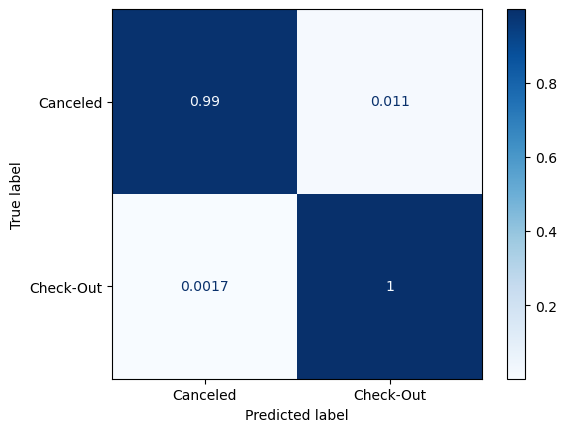

In [24]:
## Generate cross-validated predictions
y_pred = cross_val_predict(model_pipeline, X, y, cv=skf, n_jobs=-1)

# print(classification_report(y_test, y_pred))
print(classification_report(y, y_pred))

# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');
ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

## Feature Importances

In [27]:
# Get feature names after transformation
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame with the correct feature names
feature_importances = pd.DataFrame(model_pipeline[-1].feature_importances_, index=feature_names, columns=['Importance'])
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).round(2)

# Get the top 10 features
feature_importances.head(10)

,Importance
num__DaysSinceBooking,0.11
cat__Country_PRT,0.07
cat__DepositType_No Deposit,0.04
cat__DepositType_Non Refund,0.04
num__TotalOfSpecialRequests,0.04
num__ADR,0.04
num__BookingDate_DaysBeforeHoliday,0.03
num__BookingDate_DaysAfterHoliday,0.03
num__RequiredCarParkingSpaces,0.02
num__LoS_Numeric,0.02


## Permutation Importances

In [30]:
# # Compute permutation importances
# result = permutation_importance(model_pipeline, X_train, y_train, scoring = 'f1', random_state=42, n_repeats=3)

# # Create a DataFrame with the correct feature names
# permutation_importances = pd.DataFrame(result.importances_mean, index=feature_names, columns=['Importance'])
# permutation_importances = permutation_importances.sort_values(by='Importance', ascending=False).round(2)

# # Get the top 10 features
# permutation_importances.head(10)

### Tree Depths

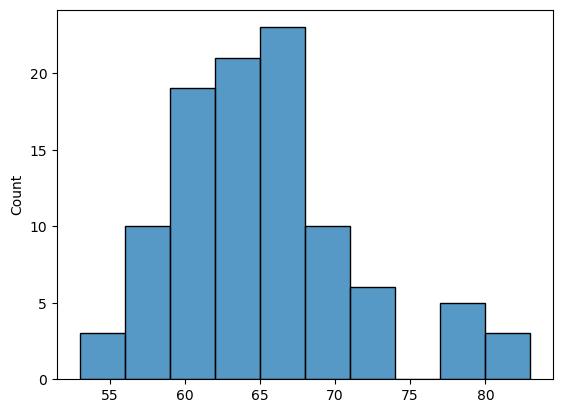

In [31]:
# Access the fitted model-
fitted_model = model_pipeline[-1]

# Now you can get the depths of the trees in the fitted model
depths = [tree.get_depth() for tree in fitted_model.estimators_]

# Plot the histogram of tree depths
sns.histplot(depths);

# Random Forest Classifer Model with Tuning

In [43]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## Create separate pipelines for categorical and numeric features

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                   sparse_output=False,
                                                   min_frequency=25,
                                                   max_categories = 100))])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

## Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## Build the full pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(
                                                    class_weight='balanced_subsample',
                                                    n_jobs=-1,
                                                    max_depth=35))])

# Fit the model and find the best hyperparameters
model_pipeline.fit(X_train, y_train)

# Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

# Evaluate the best model using cross_val_score
cv_scores = cross_val_score(model_pipeline, X, y, cv=skf, scoring='f1_micro', n_jobs=-1)

print(f'\nCross-Validation Scores: {cv_scores}\n'
      f'Mean CV Score: {cv_scores.mean():,.3f}\n'
      f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')


Cross-Validation Scores: [0.9910716  0.99155396 0.99125122 0.99147821 0.99114718]
Mean CV Score: 0.991
Standard Deviation of CV Scores: 0.000



In [44]:
# Score the model on both training and test sets
train_score = model_pipeline.score(X_train, y_train)
test_score = model_pipeline.score(X_test, y_test)

print(f"Training set score: {train_score}")
print(f"Test set score: {test_score}")

Training set score: 0.9989255583439475
Test set score: 0.9896717664684251


              precision    recall  f1-score   support

    Canceled       0.99      0.98      0.99    198441
   Check-Out       0.99      1.00      0.99    330206

    accuracy                           0.99    528647
   macro avg       0.99      0.99      0.99    528647
weighted avg       0.99      0.99      0.99    528647



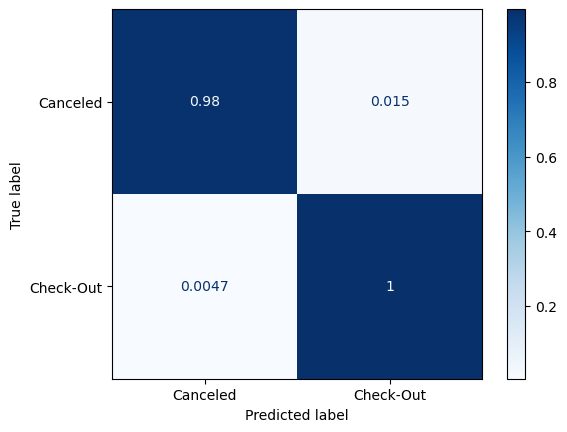

In [45]:
## Generate cross-validated predictions
y_pred = cross_val_predict(model_pipeline, X, y, cv=skf, n_jobs=-1)

# print(classification_report(y_test, y_pred))
print(classification_report(y, y_pred))

# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');
ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

In [40]:
# # Select categorical and numerical features
# cat_feats = X.select_dtypes(include=['object']).columns
# num_feats = X.select_dtypes(include=['number']).columns

# ## Create separate pipelines for categorical and numeric features

# cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
#                          ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
#                                                    sparse_output=False,
#                                                    min_frequency=25,
#                                                    max_categories = 100))])

# num_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean'))
# ])

# ## Combine transformers into a single ColumnTransformer
# preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
#                                                ('cat', cat_pipeline, cat_feats)])

# ## Build the full pipeline
# model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                                  ('classifier', RandomForestClassifier(class_weight='balanced_subsample'))
#                                  ])

# # Set up hyperparameter tuning 
# param_grid = {
#     # 'preprocessor__cat__encoder__min_frequency': [10, 25, 50],
#     # 'preprocessor__cat__encoder__max_categories': [50, 100],
#     'classifier__max_depth': [40, 55],
#     # 'classifier__min_samples_split': [2, 3],
#     # 'classifier__min_samples_leaf': [1, 2, 3]
# }

# # Define the stratified k-fold cross-validator
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # search = RandomizedSearchCV(model_pipeline,
# #                             param_distributions=param_grid,
# #                             scoring='f1',
# #                             cv=skf,
# #                             n_iter=50,
# #                             # n_jobs=-1,
# #                             random_state=42)

# search = GridSearchCV(model_pipeline,
#                       param_grid=param_grid,
#                       scoring='f1',
#                       cv=skf,
#                     #   n_jobs=-1
#                       )

# # Fit the model and find the best hyperparameters
# search.fit(X_train, y_train)

# # Extract the best model
# best_model = search.best_estimator_

# # Evaluate the best model using cross_val_score
# cv_scores = cross_val_score(best_model, X, y, cv=skf, scoring='f1', n_jobs=-1)

# print(f'\nCross-Validation Scores: {cv_scores}\n'
#       f'Mean CV Score: {cv_scores.mean():,.3f}\n'
#       f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')

## RFC Model w/ Tuning Results

### Scoring

In [ ]:
y_pred = cross_val_predict(model_pipeline, X, y, cv=skf, n_jobs=-1)

# print(classification_report(y_test, y_pred))
print(classification_report(y, y_pred))

# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');
ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

### Permutation Importances

In [46]:
# Calculate permutation importances
result = permutation_importance(
                                # best_model,
                                model_pipeline,
                                X_test, 
                                y_test,
                                n_jobs=-1,
                                scoring = 'f1')

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

ValueError: pos_label=1 is not a valid label: It should be one of ['Canceled' 'Check-Out']

## SHAP - RFC

In [ ]:
X_train_xf = best_model.named_steps.preprocessor.fit_transform(X_train)
X_test_xf = best_model.named_steps.preprocessor.transform(X_test)

In [ ]:
X_shap_train = shap.sample(X_train_xf, 500)
y_shap_train = y_train.loc[X_shap_train.index]

X_shap_test = shap.sample(X_test_xf, 500)
y_shap_test = y_test.loc[X_shap_test.index]

In [ ]:
explainer = shap.Explainer(best_model.named_steps.classifier, X_shap_train)
# shap_values_train = explainer(X_shap_train)
shap_values_test = explainer(X_shap_test)

In [ ]:
# print(shap_values_train.shape)
print(shap_values_test.shape)

### Summary Plot

In [ ]:
shap.summary_plot(shap_values_test[:, :, 0], X_shap_train)

In [ ]:
# df_data.groupby(['Country'])[['ReservationStatus']].value_counts(normalize=True).loc['PRT']

### Force Plot

In [ ]:
# For multiple predictions
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

# `HistGradientBoostingClassifier` Approach

In [ ]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              max_categories=200))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    # ('yeojohnson', PowerTransformer(method='yeo-johnson')),
    # ('scaler', StandardScaler())
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Create the RandomForestClassifier model
classifier = HistGradientBoostingClassifier(class_weight='balanced',
                                            scoring = 'f1_weighted')

hgbr_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Use joblib for parallel processing
with parallel_backend('loky', n_jobs=-1):
    
    # Fit the model and generate predictions
    hgbr_model_pipeline.fit(X_train, y_train)

hgbr_y_pred = hgbr_model_pipeline.predict(X_test)

# Evaluate performance metrics
hgbr_score_training = hgbr_model_pipeline.score(X_train, y_train)
hgbr_score_testing = hgbr_model_pipeline.score(X_test, y_test)

In [ ]:
classification_results(model_pipeline = hgbr_model_pipeline,
                       X_train = X_train,
                       X_test = X_test,
                       y_train = y_train,
                       y_test = y_test);

In [ ]:
# Calculate permutation importances
result = permutation_importance(hgbr_model_pipeline,X_test, y_test,n_jobs=-1)

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

## SHAP - HGBR

In [ ]:
X_train_xf = hgbr_model_pipeline.named_steps.preprocessor.fit_transform(X_train)
X_train_xf

In [ ]:
X_shap = shap.sample(X_train_xf, 10000)
X_shap

In [ ]:
y_shap = y_train.loc[X_shap.index]
y_shap

In [ ]:
hgbr_model_pipeline

In [ ]:
# explainer = shap.Explainer(hgbr_model_pipeline.named_steps.classifier, X_shap)
explainer = shap.Explainer(hgbr_model_pipeline.named_steps['classifier'])
shap_values = explainer(X_shap)
shap_values.shape

## Summary Plot

In [ ]:
shap.summary_plot(shap_values, X_shap)

# Results and Recommendations

Based on the SHAP results, **we can infer characteristics of guests who are less likely to cancel their reservations.** These characteristics can help define the target market for the hotels to minimize cancellations. Here's an example of an ideal target market:

## Target Market for Minimizing Hotel Reservation Cancellations

1. **Length of Stay**:
   - **Profile**: Guests who book longer stays.
   - **Reason**: Longer stays are associated with a lower likelihood of cancellation.

2. **Days Since Booking**:
   - **Profile**: Guests who book well in advance.
   - **Reason**: A higher number of days since booking indicates a lower likelihood of cancellation.

3. **Deposit Type**:
   - **Profile**: Guests willing to make non-refundable deposits.
   - **Reason**: Non-refundable deposits significantly reduce the likelihood of cancellation.

4. **Country of Origin**:
   - **Profile**: Guests from specific countries like Portugal (PRT).
   - **Reason**: Guests from certain countries show a lower likelihood of cancellation.

5. **Market Segment**:
   - **Profile**: Guests booking through Online Travel Agents (OTA).
   - **Reason**: Bookings through OTAs are less likely to be canceled.


## Example Target Market Persona:

### **1. Business Traveler:**
- **Length of Stay**: 4-7 days
- **Booking Time**: At least 2-3 months in advance
- **Deposit**: Non-refundable
- **Country**: Portugal (PRT) or other identified low-cancellation countries
- **Booking Channel**: Online Travel Agent (OTA)
- **Travel Period**: Not immediately before or after major holidays
- **Customer Type**: Individual transient
- **Booking Changes**: Minimal to no changes post-booking

### **2. Family Vacationers:**
- **Length of Stay**: 5-10 days
- **Booking Time**: 3-6 months in advance
- **Deposit**: Non-refundable
- **Country**: Identified low-cancellation countries (e.g., Portugal)
- **Booking Channel**: OTA or direct website booking
- **Travel Period**: Booking dates that avoid peak holiday disruptions
- **Customer Type**: Transient, not part of group deals
- **Booking Changes**: Stable itinerary with few changes

## Marketing Strategies:

1. **Early Bird Promotions**: Encourage early bookings with attractive discounts for longer stays.
2. **Non-Refundable Deposit Discounts**: Offer special rates for bookings with non-refundable deposits.
3. **Country-Specific Campaigns**: Tailor marketing efforts towards countries with lower cancellation rates.
4. **OTA Partnerships**: Strengthen relationships with online travel agents to attract more reliable bookings.
5. **Holiday Package Adjustments**: Optimize packages and promotions to avoid booking peaks right before or after holidays.
6. **Loyalty Programs for Transient Guests**: Create loyalty programs that cater to individual transient travelers with stable travel plans.
7. **Agent Performance Monitoring**: Monitor and incentivize agents with better non-cancellation records to maintain quality bookings.

By focusing on these customer profiles and implementing targeted marketing strategies, the hotel can effectively reduce reservation cancellations and optimize their booking stability.